In [1]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities")
nlp.add_pipe("merge_noun_chunks")
import json
from matplotlib import pyplot as plt
import cv2
from elasticsearch import Elasticsearch
import re

In [2]:
from elasticsearch import helpers
client = Elasticsearch(
    "http://localhost:9200",
     basic_auth=("elastic", "elastic")

)
resp = client.info()

In [3]:
class question_matcher:
    def __init__(self):
        self.patterns= []
        self.q_json = self.get_questions_json()
        self.matcher = Matcher(nlp.vocab)

    def get_questions_json(self):
        with open('questions.json', 'r') as f:
            pat = json.load(f)
        return pat
    
    def define_keyword(self,question:str):
        for q in self.q_json:
            if q['keyword'] in question.lower():
                keyword = q['keyword']
                index = q['qid']
        return keyword, index

    def get_focus(self,question:str,ind,pattern):
        focus =''
        focus_pos = pattern['focus']
        token_q = [token.text for token in nlp(question)]
        i = 0
        start = 0
        for token in focus_pos[ind].split():
            if(token == 'sf'):
                start = 1
                continue
                
            if(token == 'ef'):
                start = 0
                return focus
                break;
            if(start == 1):
                focus = focus + ' ' + token_q[i]
            i = i + 1
        return focus
    
    def re_get_focus(self,question:str,ind,pattern):
        question_token = [token.text for token in nlp(question)]
        focus = ''
        focus_pos = pattern['focus']
        start = 0
        i = 0
        for token in focus_pos[ind].split('\s*'):
                if(token == 'sf'):
                    start = 1
                    i = i - 1
                    continue

                if(token == 'ef'):
                    start = 0
                    break

                if(token == ".*" and start == 1):
                    j = i
                    while(j < len(question_token)):
                        focus = focus + ' ' + question_token[j]
                        j = j + 1
                    focus = focus.strip()
                    print(focus)
                    return focus

                if(start == 1):
                    focus = focus + ' ' + question_token[i]
                
                i = i + 1

                # if(i == len(question_token)):
                #     print(i)
                #     break

        focus = focus.strip()
        print(focus)
        return focus

    def match_pattern(self,question):
        q_pos = [token.pos_ for token in nlp(question)]
        keyword, index = self.define_keyword(question)
        for pattern in self.q_json[index]['patterns']:
            pos = self.pattern_to_pos(pattern['pos'])
            self.matcher.add(p, pos)
            doc = nlp(question)
            matches = self.matcher(doc)
            if matches != []:
                for match_id, start, end in matches:
                    string_id = nlp.vocab.strings[match_id]
                    span = doc[start:end]
                    print(string_id)
                    print(q_pos)
                    print(pattern['pos'])
                    print(match_id)
            else:
                print('fail')

    def re_match_pattern(self,question):
        found = 0
        doc = nlp(question)
        ltoken = [token.pos_ for token in nlp(question)]
        q_pattern = ''
        for token in doc:
            q_pattern = q_pattern + token.pos_ + ' ' 
        keyword, index = self.define_keyword(question)
        for pattern in self.q_json[index]['patterns']:
            matched_pos=0
            for pos in pattern['pos']:
                regexpos  = f'({pos})'
                matches = re.fullmatch(regexpos, q_pattern)
                if matches != None:
                    print('Matched!')
                    print(matches.string)
                    print(pos)
                    print(pattern['pattern'])
                    focus = self.re_get_focus(question,matched_pos,pattern)
                    found = 1
                    return focus
                matched_pos = matched_pos + 1
            if found == 1:
                break
            


    def on_match(self,matcher, doc, id, matches):
        print('Matched!', matches)


    def pattern_to_pos(self, patterns:list):
        pos = []
        pattern = []
        for p in patterns:
            
            itr = []
            pattern.append(p)
            for token in p.split():
                if token != '*':
                    itr.append({'POS':token})
                else:
                    itr.append({})
            pos.append(itr)
        return pos
qm = question_matcher()


In [4]:
qm.re_match_pattern("who is mike tyson")

Matched!
PRON AUX PROPN 
\s*PRON\s*(AUX|VERB)\s*(NOUN|PROPN)\s
who [is,was] [NAME]
mike tyson


'mike tyson'

In [4]:

class sys:
    def __init__(self):
        self.image_ids =[]
        self.image_caption =[]

    def search(self,query):
        self.image_ids =[]
        self.image_caption =[]
        query = {
            "match": {
            "caption": query
            }
        }
        resp = client.search(index="cocomo", query=query,size=20)
        print("Got %d Hits:" % resp['hits']['total']['value'])
        for hit in resp['hits']['hits']:
            #  print(\"%(caption)s : %(image_id)s : %(id)s\" % hit[\"_source\"])\n",
            self.image_ids.append(hit['_source']['image_id'])
            self.image_caption.append(hit['_source']['caption'])
        self.display();
        
    def display(self):
        i = 0
        plt.figure(figsize=(25,50))
        columns = 2
        for i, id in enumerate(self.image_ids):
            plt.subplot(10, 3, i + 1)
            path = '..\\..\\Cocomo2014\\\\val2014\\\\val2014\\COCO_val2014_'+ '0'*(12 - len(str(id))) + str(id) +'.jpg'
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.title(self.image_caption[i])
            plt.imshow(img)
ir = sys()


In [70]:
class system:
    def __init__(self):
        qm = question_matcher()
        ir = sys()
    
    def search(self,question):
        focus =  qm.re_match_pattern(question)
        print(focus)
        ir.search(focus)
s = system()

Matched!
PRON AUX NOUN ADP PROPN 
\s*PRON\s*AUX\s*(NOUN|PROPN)\s*.*\s*
who [is,was] [NAME]
the president of united states
the president of united states
Got 10000 Hits:


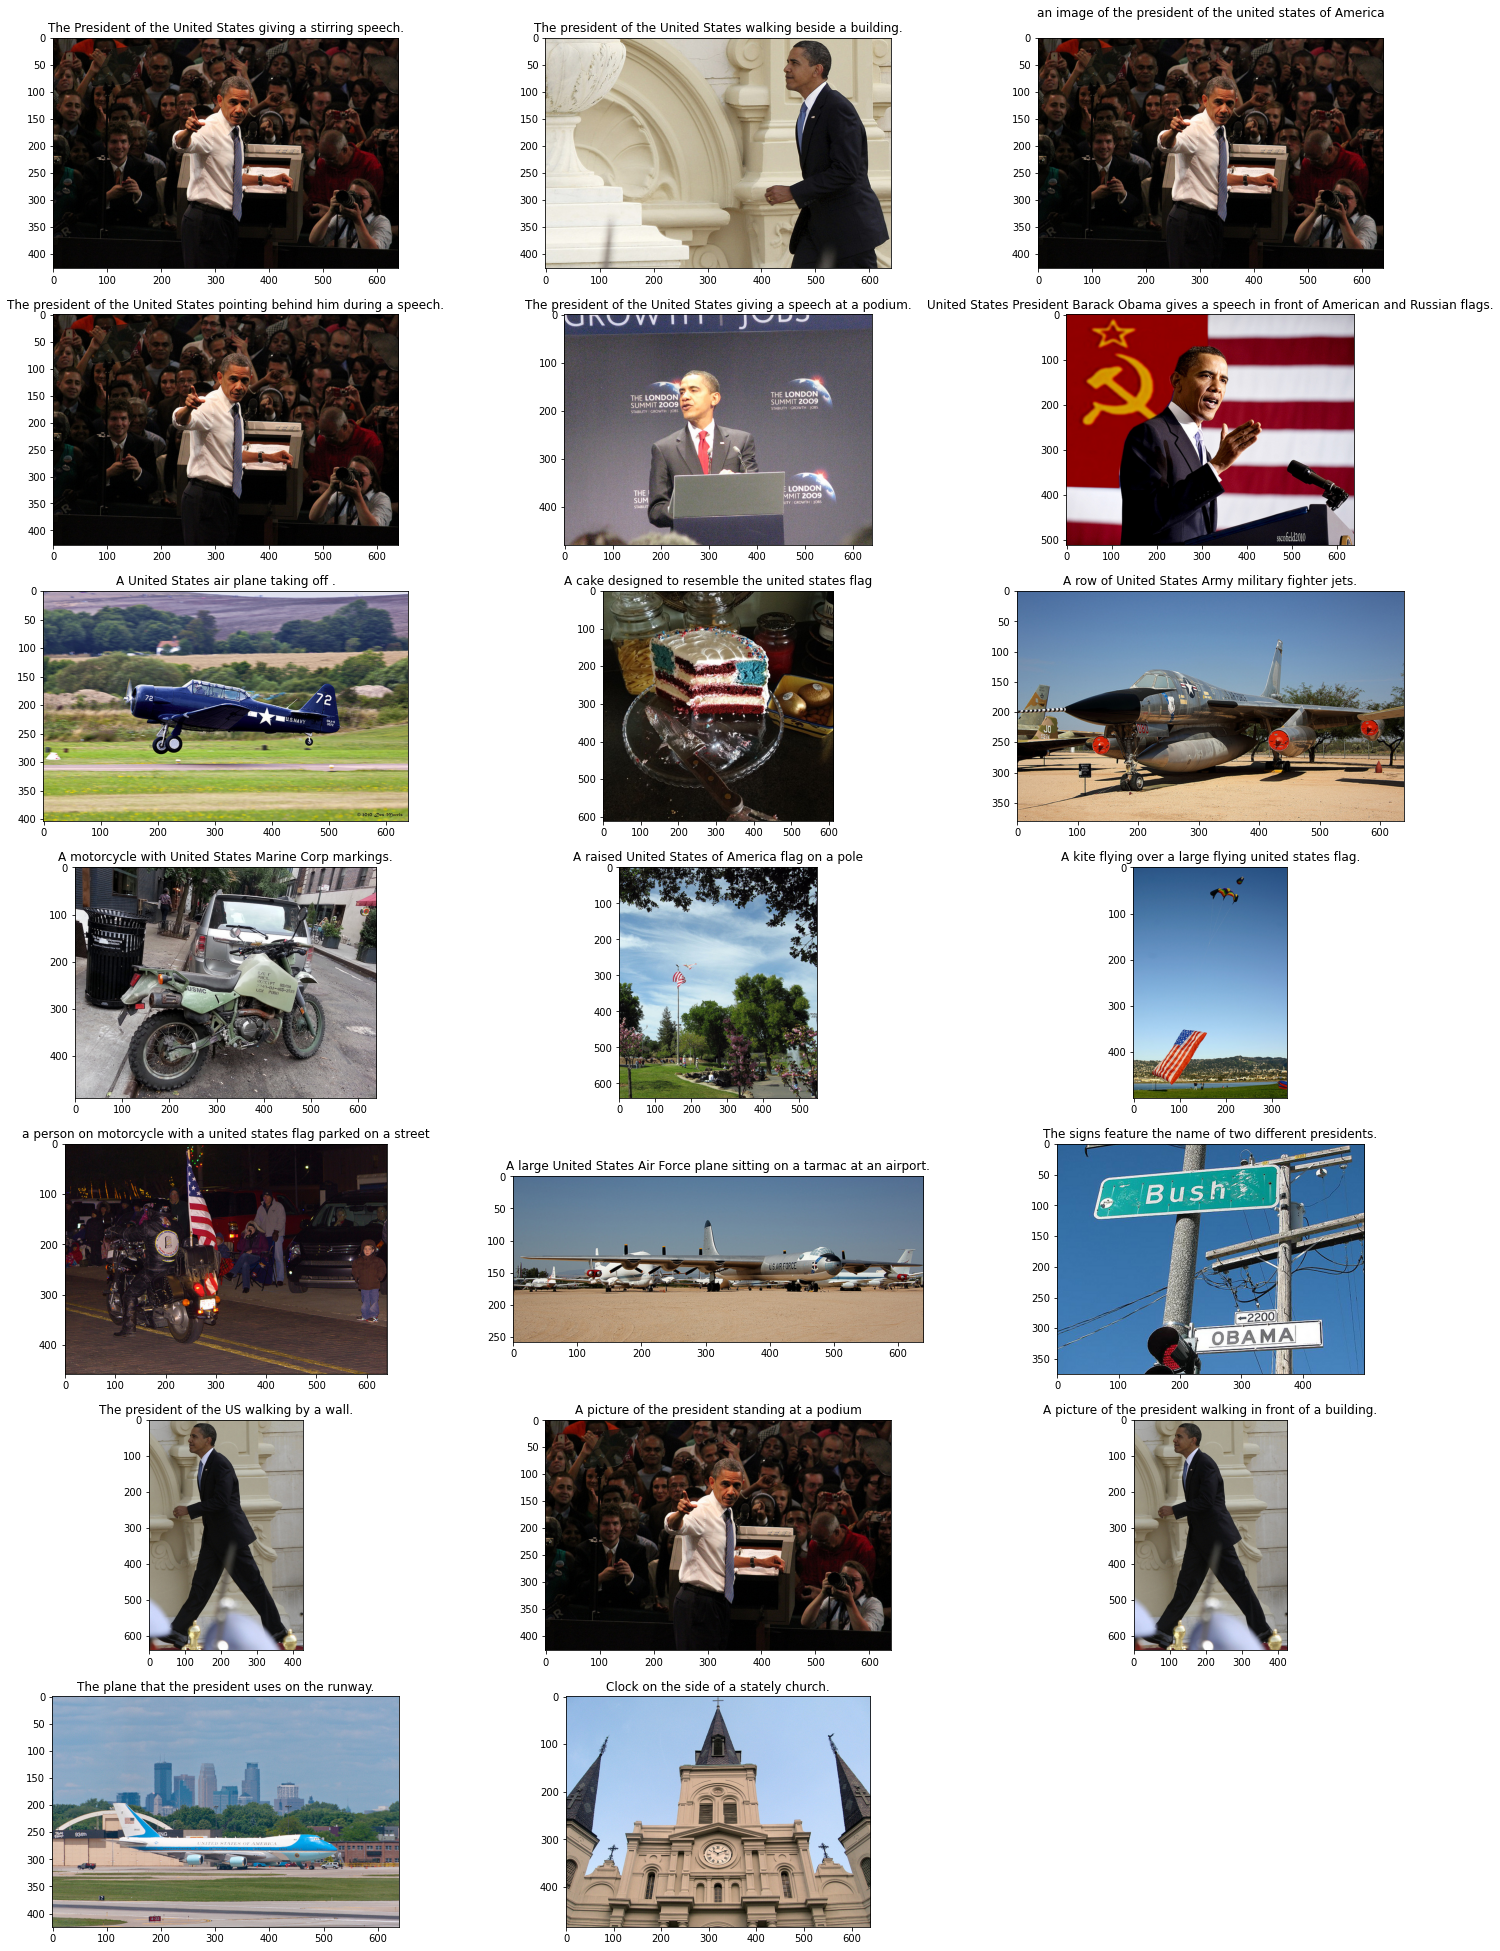

In [71]:
s.search("who is the president of united states")

In [102]:
with open('questions.json', 'r') as f:
    patt = json.load(f)



In [46]:
doc = nlp("What did Vincent Van Gogh paint")
print( [token.pos_ for token in doc])
print( [token.text for token in doc])

['PRON', 'VERB', 'NOUN']
['What', 'did', 'Vincent Van Gogh paint']


In [124]:
doc = nlp("when did Bill Gates graduate college")
print( [token.pos_ for token in doc])
print( [token.text for token in doc])

['SCONJ', 'VERB', 'PROPN', 'VERB', 'NOUN']
['when', 'did', 'Bill Gates', 'graduate', 'college']


In [47]:
pos = '.'
patteee = f'({".*"})'
matches = re.fullmatch(patteee, "llllllll   ll")
print(matches)

<re.Match object; span=(0, 8), match='llllllll'>
